In [ ]:
!pip3 install bert-tensorflow==1.0.1
!pip3 install tensorflow==2.3.0
!pip3 install tensorflow-addons

In [ ]:
import os
import tensorflow as tf
tf.gfile = tf.io.gfile # changed from tf1 to tf2
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from bert.tokenization import FullTokenizer
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pickle
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import Image

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
# max length for BERT
max_len = 128

# different BERT models
bert_model_links = ['https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2', 
                  'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2',
                  'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2',
                  'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2']

bert_model = 'L2H128A2'

# importing data
train = np.load('PATH TO data.npz')
test = np.load('PATH TO test.npz')

# splitting data
train_data = train['a']
train_labels = train['b']

test_data = test['a']
test_labels = test['b']

In [ ]:
# defining BERT model that will be used
Bert_layer = hub.KerasLayer(bert_model_links[3], trainable=True)

In [ ]:
# processing functions

# distinguish padding from real word ids
def get_masks(tokens, max_len):
    if len(tokens)>max_len:
        #Cutting down the excess length
        tokens = tokens[0:max_len]
        return [1]*len(tokens)
    else:
        return [1]*len(tokens) + [0] * (max_len - len(tokens))

# needed to sentencize
def get_segments(tokens, max_len):
    if len(tokens)>max_len:
        #Cutting down the excess length
        tokens = tokens[:max_len]
        segments = []
        current_segment_id = 0
        for token in tokens:
            segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
        return segments
    else:
        segments = []
        current_segment_id = 0
        for token in tokens:
            segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
        return segments + [0] * (max_len - len(tokens))


# a bow model
def get_ids(tokens, tokenizer, max_len):    
    if len(tokens)>max_len:
        tokens = tokens[:max_len]
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        return token_ids
    else:
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids = token_ids + [0] * (max_len-len(token_ids))
        return input_ids

# create vocab file
vocab_file = Bert_layer.resolved_object.vocab_file.asset_path.numpy()
# lower case
do_lower_case = Bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer
tokenizer = FullTokenizer(vocab_file, do_lower_case)

# preprocessing function
def bert_encode(texts):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        stokens = tokenizer.tokenize(text)
        stokens = ["[CLS]"] + stokens + ["[SEP]"]
        
        input_ids = get_ids(stokens, tokenizer, max_len)
        input_masks = get_masks(stokens, max_len)
        input_segments = get_segments(stokens, max_len)
        
        all_tokens.append(input_ids)
        all_masks.append(input_masks)
        all_segments.append(input_segments)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def review_to_words(raw_body):
    body_text = BeautifulSoup(raw_body).get_text() 
    return(body_text)  

In [ ]:
# transforming review data
train_text = [review_to_words(x) for x in train_data]
test_text =  [review_to_words(x) for x in test_data]

In [ ]:
# encoding train and test text to create input for the model
train_input = bert_encode(train_text)
test_input = bert_encode(test_text)

test_labels = test_labels.astype(float)
train_labels = train_labels.astype(float)

In [ ]:
# defining metrics to be used
METRICS = [ 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tfa.metrics.F1Score(name='f1', num_classes=1, average='micro')
]


def create_model():
  input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

  output = Bert_layer({"input_word_ids": input_word_ids, "input_mask": input_mask, 
                                              "input_type_ids": input_type_ids})
  sequence_output = output['sequence_output']
  clf_output = sequence_output[:, 0, :]
  mean = tf.reduce_mean(sequence_output, 1)
  out = Dense(512, activation='relu')(clf_output)

  final = Dense(1, activation='sigmoid')(out)

  
  return [[input_word_ids, input_mask, input_type_ids], final]

values = create_model()
model = Model(inputs=values[0], outputs=values[1])

# compile model
model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=METRICS)

model.summary()

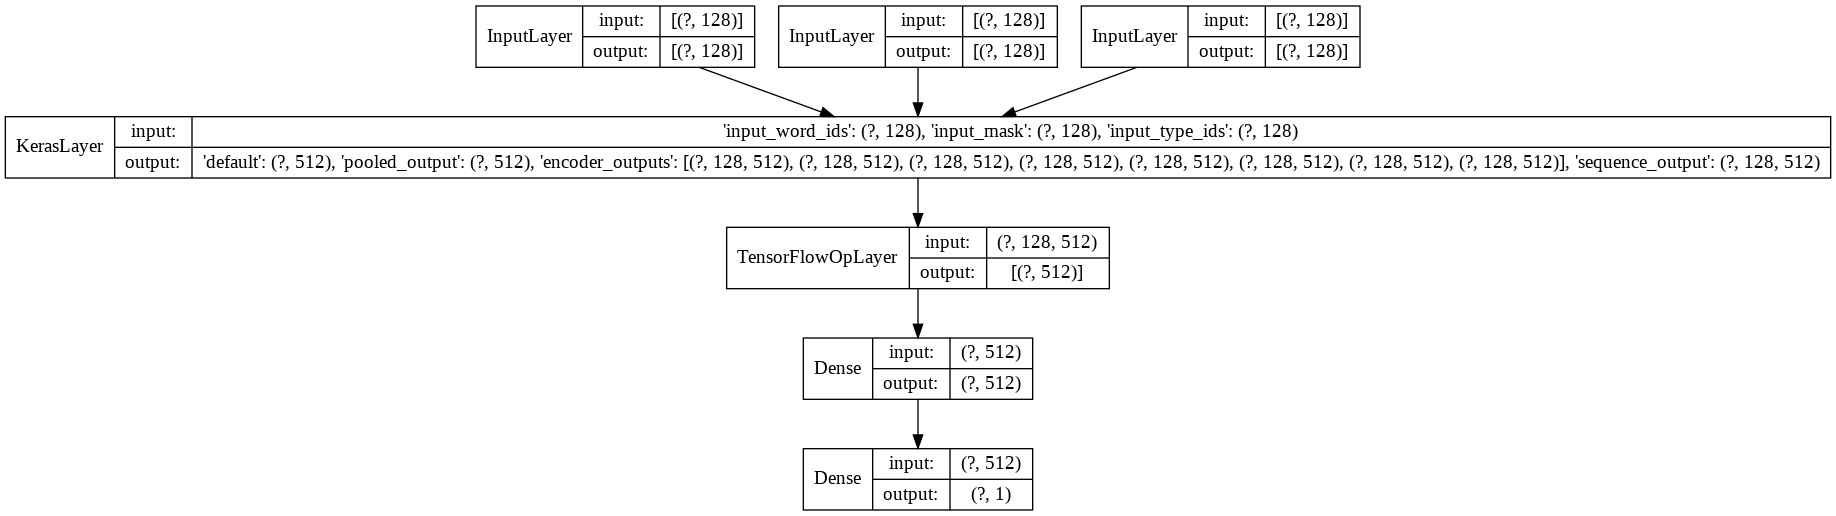

In [ ]:
# plotting model for visual representation
plot_model(model,show_layer_names  = False,show_shapes = True)

In [22]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-2,
        patience=2,
        verbose=1)
]

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=12,
    callbacks=callbacks
)

# saving train history
with open('history', 'wb') as f:
    pickle.dump(train_history.history, f)

Epoch 1/5
1667/1667 [==============================] - 223s 134ms/step - loss: 0.1779 - accuracy: 0.9298 - recall: 0.9304 - precision: 0.9292 - f1: 0.6663 - val_loss: 0.3881 - val_accuracy: 0.8552 - val_recall: 0.8632 - val_precision: 0.8504 - val_f1: 0.6681
Epoch 2/5
1667/1667 [==============================] - 231s 139ms/step - loss: 0.1566 - accuracy: 0.9395 - recall: 0.9373 - precision: 0.9413 - f1: 0.6663 - val_loss: 0.4462 - val_accuracy: 0.8520 - val_recall: 0.7986 - val_precision: 0.8950 - val_f1: 0.6681
Epoch 3/5
1063/1667 [==================>...........] - ETA: 1:17 - loss: 0.1316 - accuracy: 0.9493 - recall: 0.9495 - precision: 0.9491 - f1: 0.6667

KeyboardInterrupt: ignored

In [23]:
# evaluating model on test data
results = model.evaluate(test_input, test_labels, batch_size=12)
print('test loss, test acc, test auc:', results)

# Evaluate on test data
417/417 [==============================] - 18s 42ms/step - loss: 0.4457 - accuracy: 0.8554 - recall: 0.8640 - precision: 0.8501 - f1: 0.6681
test loss, test acc, test auc: [0.4457170367240906, 0.855400025844574, 0.8640350699424744, 0.8501372933387756, 0.6680874228477478]


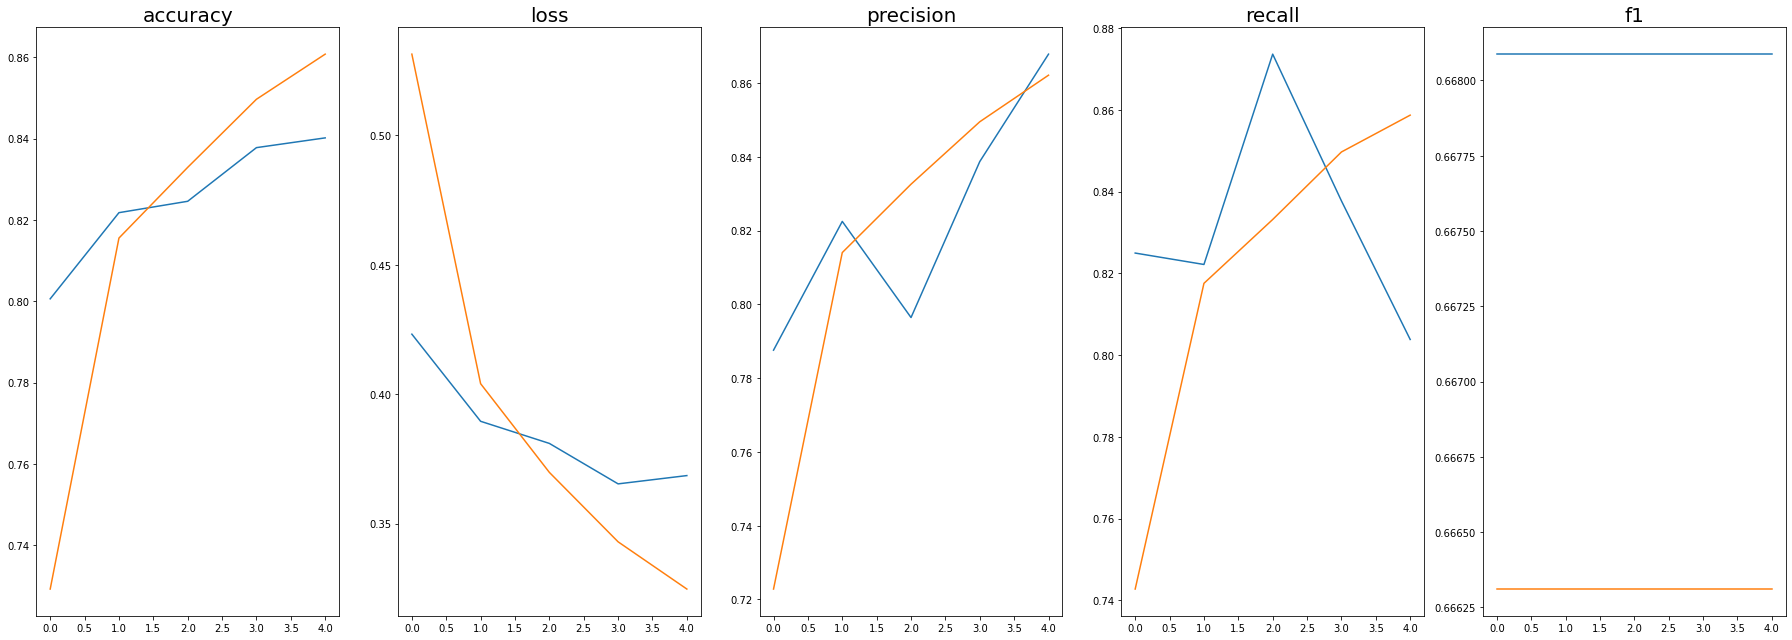

In [ ]:
# plotting metrics
with open('history', 'rb') as f:
        data = pickle.load(f)
        f.close()

plt.figure(figsize=(25, 9))
i = 0
epoch = list(range(5))

for _ in ["accuracy","loss", "precision", "recall", "f1"]:
        i += 1
        plt.subplot(1, 5, i)
        val = data["val_"+_]
        train = data[_]
        plt.title(_ ,fontsize=20)
        plt.plot(epoch,val,train)
        
plt.tight_layout()